In [1]:
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("..")
import numpy as np

def get_all_params_flattend(model):
    params = np.array([], dtype=np.float32)
    with torch.no_grad():
        params = np.concatenate((params, model.conv1.weight.data.reshape(-1)))
        params = np.concatenate((params, model.conv1.bias.data.reshape(-1)))
        params = np.concatenate((params, model.conv2.weight.data.reshape(-1)))
        params = np.concatenate((params, model.conv2.bias.data.reshape(-1)))
        params = np.concatenate((params, model.fc1.weight.data.reshape(-1)))
        params = np.concatenate((params, model.fc1.bias.data.reshape(-1)))
        params = np.concatenate((params, model.fc2.weight.data.reshape(-1)))
        params = np.concatenate((params, model.fc1.bias.data.reshape(-1)))
    return params

from sklearn.preprocessing import StandardScaler
def standardization(all_params):
    all_params = StandardScaler().fit_transform(all_params)
    return all_params

from sklearn.decomposition import PCA
def draw_pca_model(params_list, colors, title):
    pca = PCA(n_components=2)
    proj = pca.fit_transform(params_list)
    figure = plt.figure(figsize=(18, 8))
    plt.title(title)
    plt.scatter(proj[:, 0], proj[:,1], c = colors, cmap="gist_rainbow")
    plt.annotate("avg_trusted", (proj[len(proj) - 2, 0], proj[len(proj) - 2, 1]), textcoords="offset points", xytext=(5,5))
    plt.annotate("server", (proj[len(proj) - 1, 0], proj[len(proj) - 1, 1]), textcoords="offset points", xytext=(5,5))
    plt.colorbar(ticks=range(41))

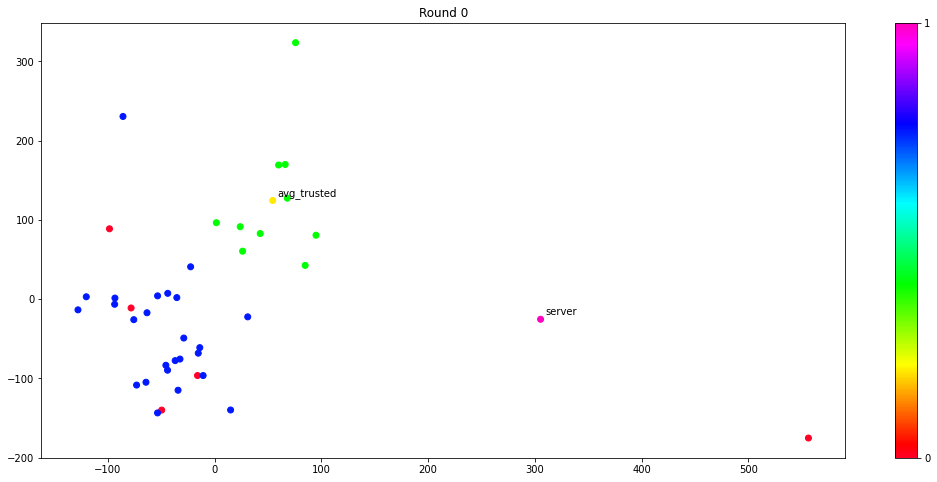

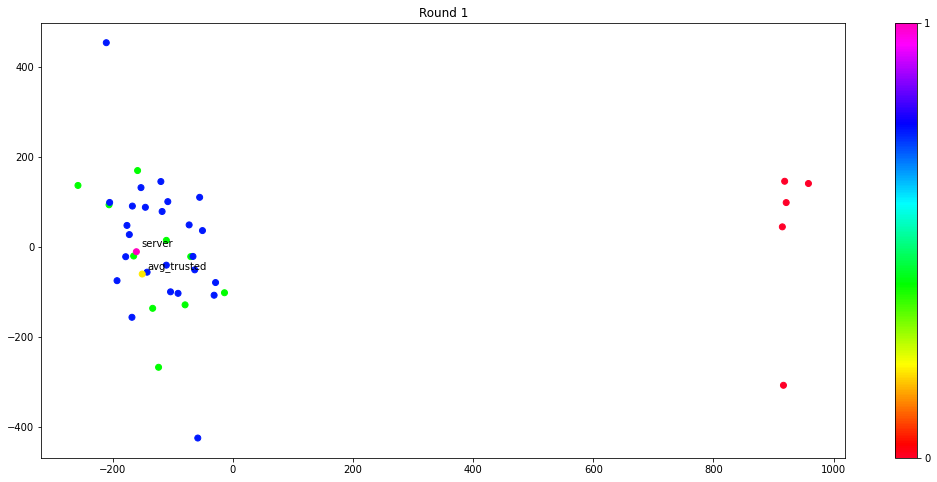

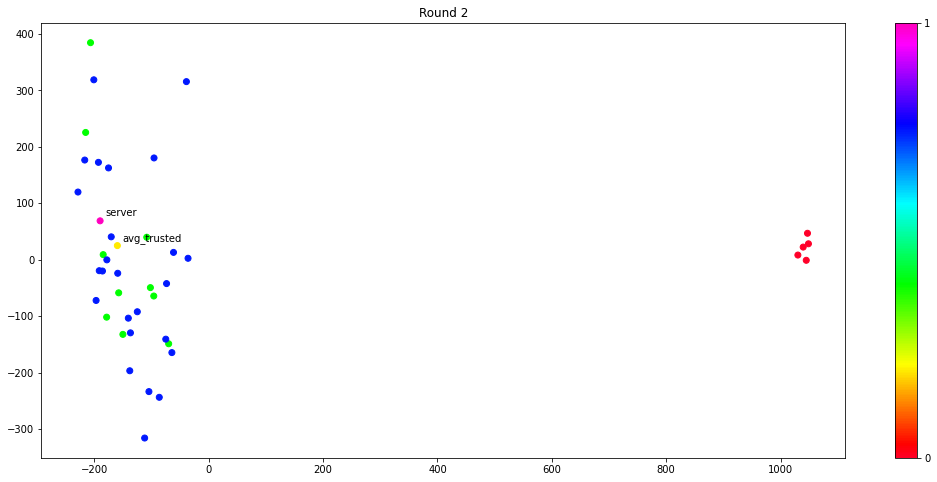

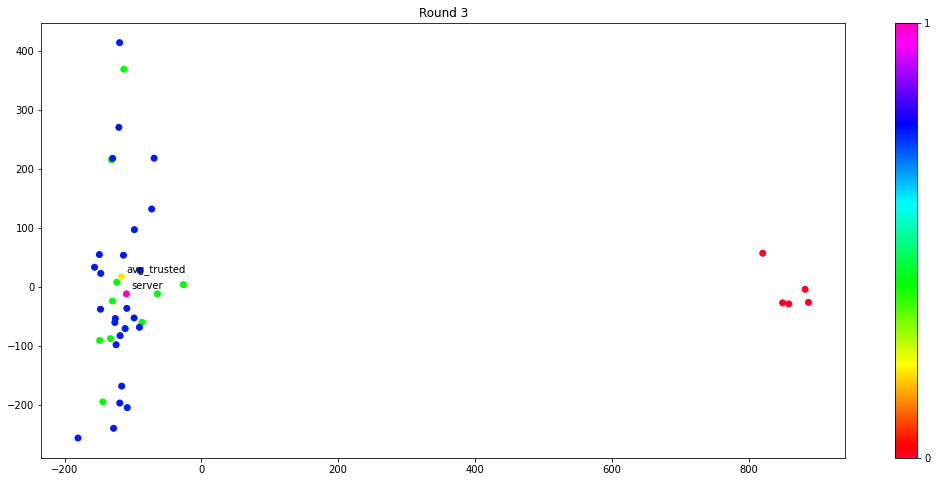

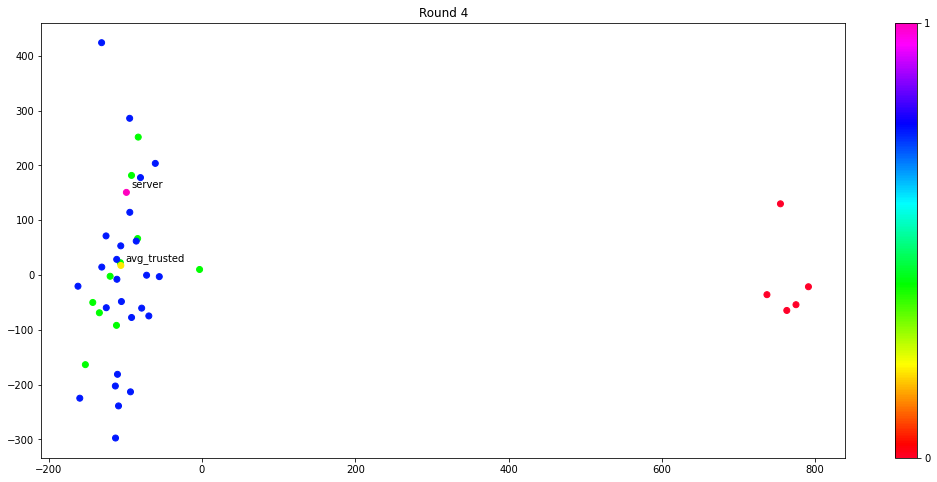

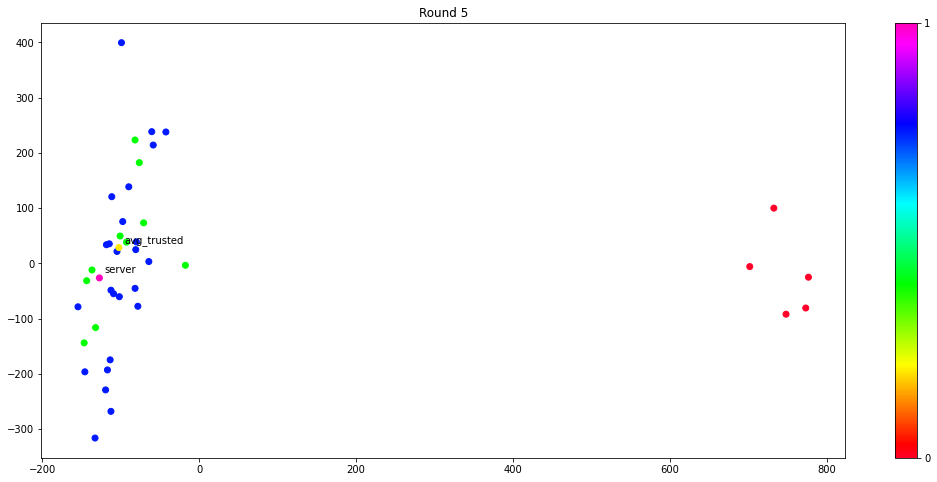

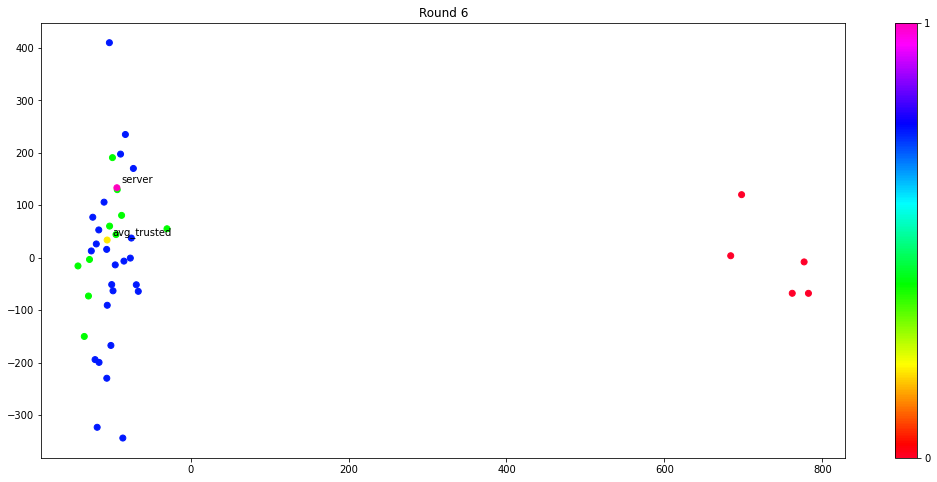

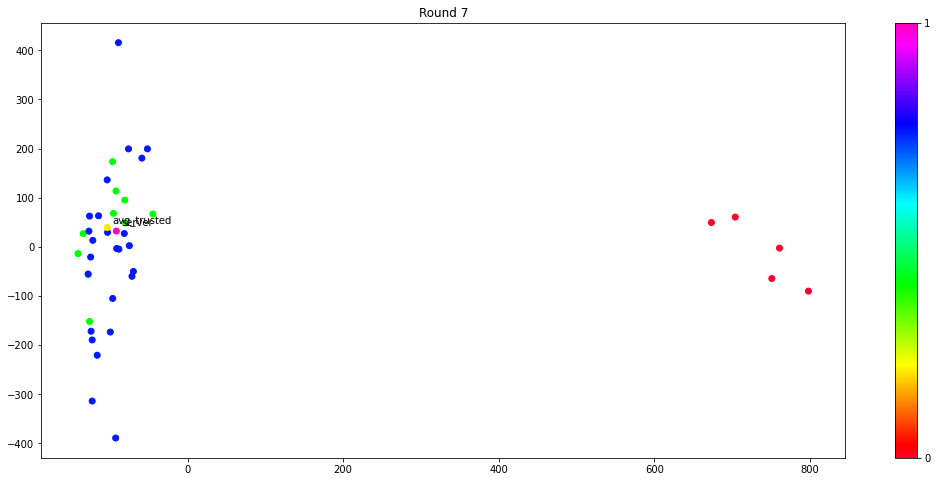

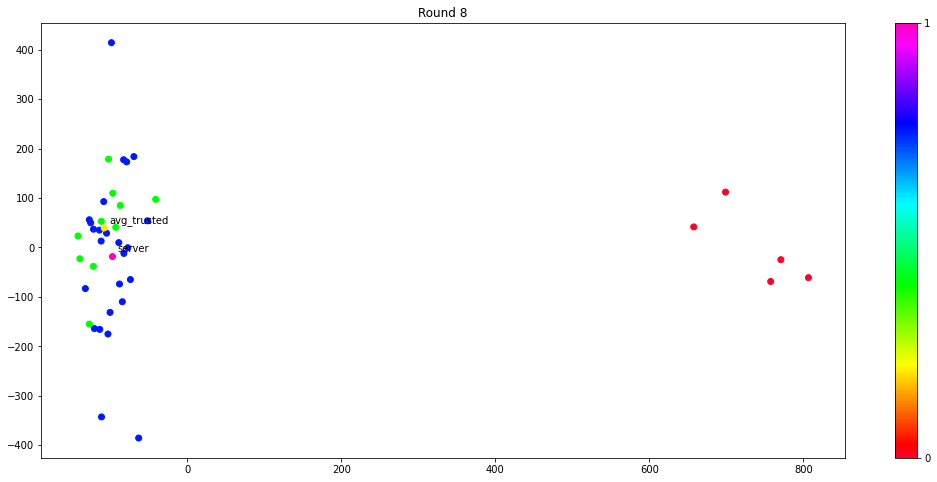

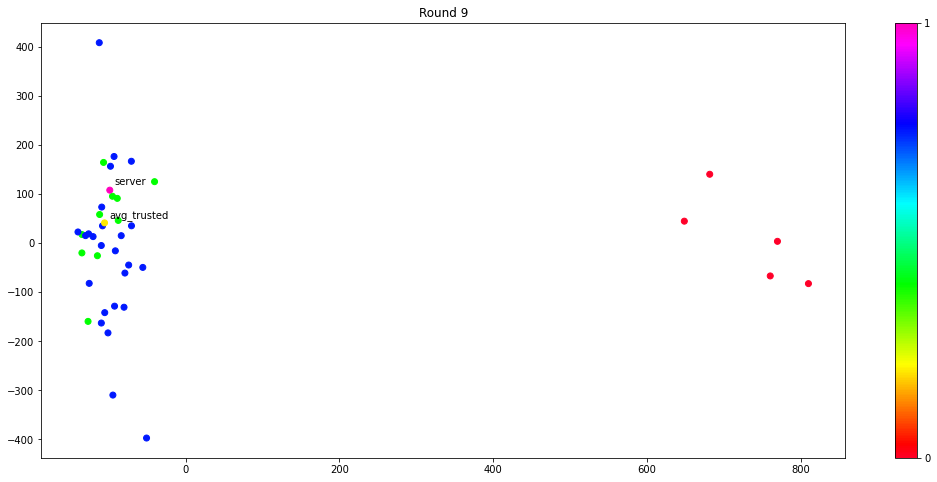

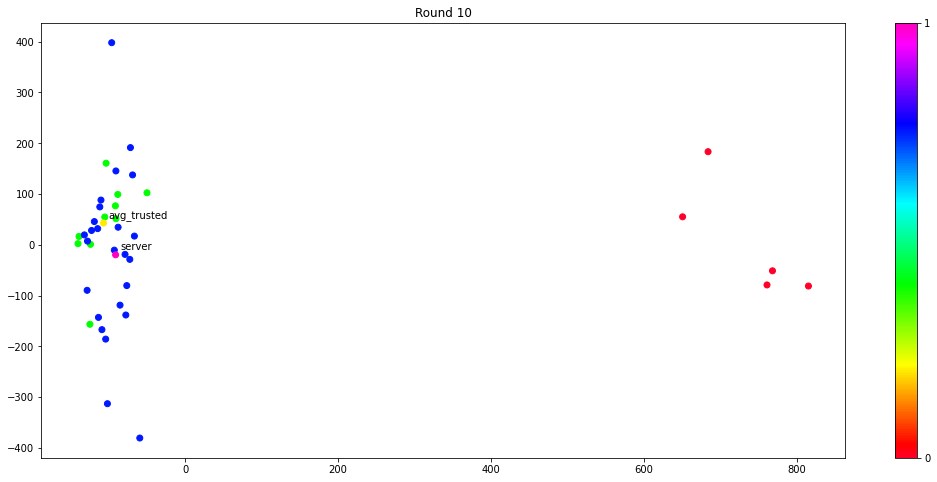

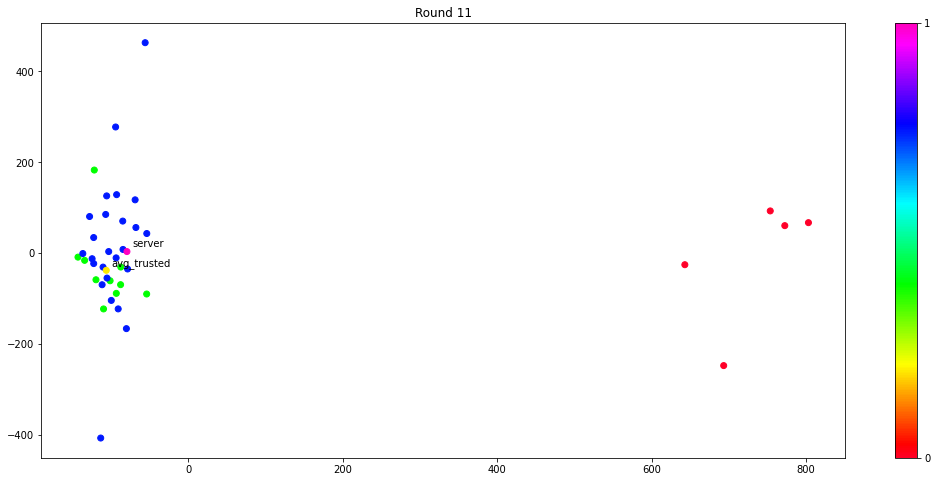

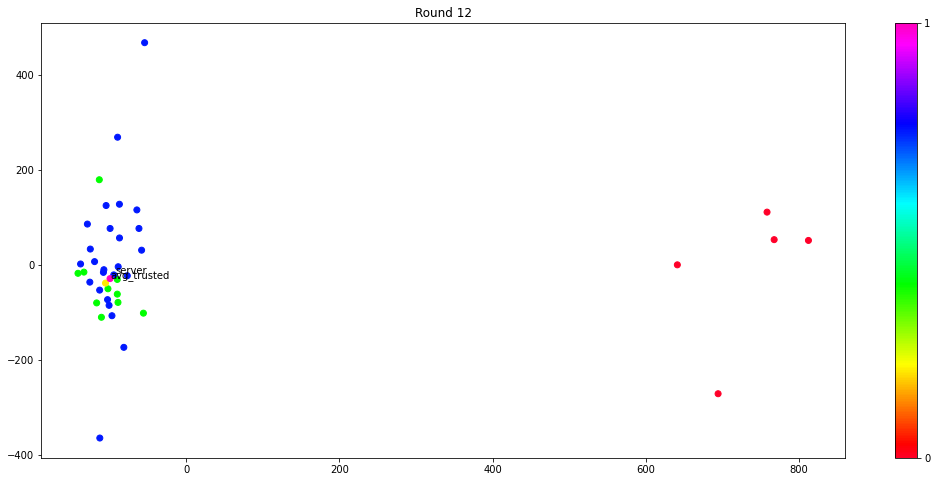

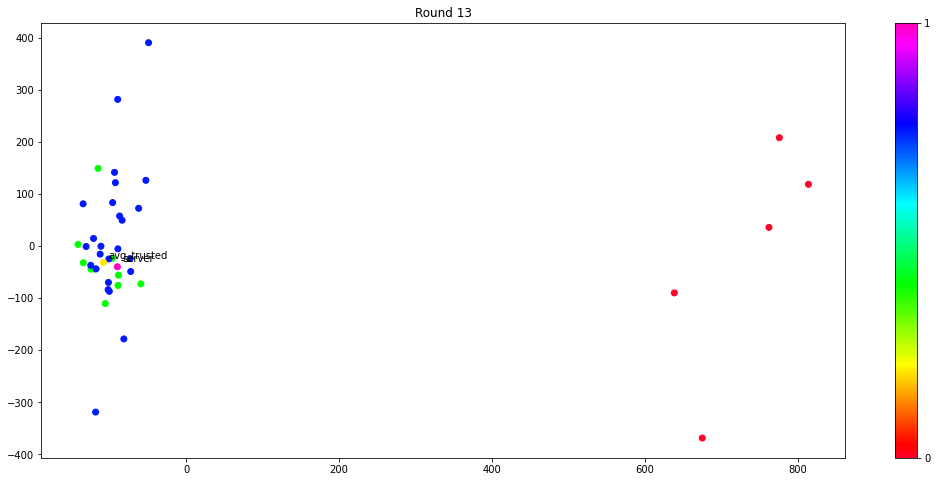

In [2]:
rounds = range(0,14, 1)
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("..")
import numpy as np

file_path = "../data_output/20201201_114610_mnist_trust5_normal_outside_W_SAN_168"

all_params = np.array([], dtype=np.float32).reshape(-1, 431570) 
# 431570 is the nmber of all params in a model

path = "{}/{}".format(file_path, "trusted")
with open(path, 'r') as f:
    trusted_idx = [str(i) for i in f.readlines()[0].replace('[','').\
                   replace(']','').replace('\n','').replace('\'','').split(', ')]
    
path = "{}/{}".format(file_path, "eavesdroppers")
with open(path, 'r') as f:
    eavesdoppers_idx = [str(i) for i in f.readlines()[0].replace('[','').\
                   replace(']','').replace('\n','').replace('\'','').split(', ')]
    
path = "{}/{}".format(file_path, "normal")
with open(path, 'r') as f:
    normal_idx = [str(i) for i in f.readlines()[0].replace('[','').\
                   replace(']','').replace('\n','').replace('\'','').split(', ')]

workers_idx = trusted_idx + eavesdoppers_idx + normal_idx

color_map = []
for ww in workers_idx:
    if ww in eavesdoppers_idx:
        color_map.append(0.0)
    elif ww in trusted_idx:
        color_map.append(0.40)
    elif ww in normal_idx:
        color_map.append(0.75)
    
# Avg model of trusted workers
color_map.append(0.2)

# For the server
color_map.append(1) 

for rr in rounds:
    all_params = np.array([], dtype=np.float32).reshape(-1, 431570) 
    # 431570 is the nmber of all params in a model
    for ww in workers_idx:
        model_path = "{}/models/R{}_{}".format(file_path, rr, ww)
        worker_model = torch.load(model_path)
        params = get_all_params_flattend(worker_model).reshape(1, -1)
        all_params = np.concatenate((all_params, params))
    
    avg_path = "{}/models/R{}_avg_trusted_model".format(file_path, rr)
    avg_model = torch.load(avg_path)
    avg_params= get_all_params_flattend(avg_model).reshape(1, -1)
    all_params = np.concatenate((all_params, avg_params))
    
    server_path = "{}/models/R{}_server_model".format(file_path, rr)
    server_model = torch.load(server_path)
    server_params= get_all_params_flattend(server_model).reshape(1, -1)
    all_params = np.concatenate((all_params, server_params))
    all_params = standardization(all_params)
    draw_pca_model(all_params, color_map, "Round {}".format(rr))

